In [1]:
import warnings
# Desactivar todas las advertencias temporalmente
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.decomposition import PCA as pca
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification
from sklearn.metrics import silhouette_score

In [2]:
df=pd.read_csv("./data/datosv2.csv")
print(df.shape)
df.head()

(81289, 469)


C:\Users\User\anaconda3\envs\MIAD\lib\site-packages\IPython\core\interactiveshell.py:3194: DtypeWarning: Columns (463) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,ID_UC,ID_OCORRENCIA,RESULTADO,N338,N342,N341,N340,N339,N337,...,ID_REGION,ID_UC_METER_TYPE,ID_UC_CLASS,ID_UC_ACTIVITY_FIELD,ID_UC_CONNECTION_TYPE,ID_LOCALITY,ID_UC_READING_CYCLE,ID_MUNICIPALITY,UC_COL_ID_05,UC_COL_ID_03
0,0,9005721560,A-10003923,10,NaN,NaN,NaN,NaN,NaN,NaN,...,50,0.0,1,NaN,NaN,1,5026.0,101,TR,90
1,1,9005781700,A-10004923,10,NaN,NaN,NaN,NaN,NaN,NaN,...,50,3.0,1,NaN,NaN,1,NaN,101,TR,90
2,2,3813704320,A-10005923,10,NaN,NaN,NaN,NaN,NaN,NaN,...,30,0.0,1,NaN,NaN,1,3014.0,102,TR,38
3,3,401600580,A-1000831,10,NaN,NaN,NaN,NaN,NaN,NaN,...,50,0.0,1,NaN,NaN,1,5030.0,101,TR,4
4,4,402400780,A-1000832,10,NaN,NaN,NaN,NaN,NaN,NaN,...,50,3.0,1,NaN,NaN,1,5030.0,101,TR,4


In [3]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(df.head(5))

   Unnamed: 0       ID_UC ID_OCORRENCIA  RESULTADO  N338  N342  N341  N340  \
0           0  9005721560    A-10003923         10   NaN   NaN   NaN   NaN   
1           1  9005781700    A-10004923         10   NaN   NaN   NaN   NaN   
2           2  3813704320    A-10005923         10   NaN   NaN   NaN   NaN   
3           3   401600580     A-1000831         10   NaN   NaN   NaN   NaN   
4           4   402400780     A-1000832         10   NaN   NaN   NaN   NaN   

   N339  N337  N276  N404  N534  N625  N624  N623  N622  N620  N621  N402  \
0   NaN   NaN   NaN     0     0   NaN   NaN   NaN   NaN   NaN   NaN     0   
1   NaN   NaN   NaN     0     0   NaN   NaN   NaN   NaN   NaN   NaN     0   
2   NaN   NaN   NaN     1     1   NaN   NaN   NaN   1.0   1.0   1.0     0   
3   NaN   NaN   NaN     0     0   NaN   NaN   NaN   NaN   NaN   NaN     0   
4   NaN   NaN   NaN     0     0   NaN   NaN   NaN   NaN   NaN   NaN     0   

   N435  N436   N665  N664  N643  N641  N639  N637  N635  N633  N596

In [4]:
def mapeo_de_variables(df : pd.DataFrame) -> pd.DataFrame:
    """genera una tabla donde muestra, para cada variable en un dataframe, su número de nulos, tipo, valores únicos y porcentaje de nulos"""
    dimension=df.shape
    variables = df.columns.to_list()
    nulos = []
    variable = []
    tipo_variable = []
    valores_unicos = []
    unicos = []
    for variable in variables:
        nulos.append(df[variable].isnull().sum())
        tipo_variable.append(df[variable].dtype)
        valores_unicos.append(len(df[variable].dropna().unique()))
        unicos.append(df[variable].dropna().unique().tolist())
    tabla = pd.DataFrame({"Variable":variables,"Nulos":nulos,"Tipo Variable":tipo_variable,"Valores Unicos": valores_unicos,"Unicos":unicos})
    tabla["Porcentaje Nulos"]=(tabla["Nulos"]/len(df))*100
    tabla.sort_values("Porcentaje Nulos",ascending=False, inplace = True)
    return tabla


In [5]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(mapeo_de_variables(df))

                  Variable  Nulos Tipo Variable  Valores Unicos  \
193                   N271  81289       float64               0   
455                   N302  81289       float64               0   
419                   N246  81289       float64               0   
279                   N156  81289       float64               0   
259                   N268  81289       float64               0   
258                   N269  81289       float64               0   
256                   N277  81289       float64               0   
433                   N192  81289       float64               0   
305                   N406  81289       float64               0   
453                   N303  81288       float64               1   
454                   N301  81288       float64               1   
292                   N336  81281       float64               2   
293                   N335  81280       float64               1   
294                   N334  81272       float64               

### Dimensiones de la data

In [6]:
df.shape

(81289, 469)

In [7]:
# Calcular la cantidad total de valores nulos en el DataFrame
total_nulos = df.isna().sum().sum()

# Calcular el porcentaje total de valores nulos
porcentaje_nulos = (total_nulos / (df.shape[0] * df.shape[1])) * 100

print(f"Porcentaje total de valores nulos en el DataFrame: {porcentaje_nulos:.2f}%")

Porcentaje total de valores nulos en el DataFrame: 26.42%


### Limpieza y estandarización preliminar de datos

In [8]:
# Las siguientes columnas se eliminan por no tener información relevante para el análisis
# Unnamed: 0, se elimina porque corresponde al número de la observación y la indexación cumple esa función
# ID_UC, se elimina la unidad de consumo porque no es relevante
# ID_OCORRENCIA, se elimina el ID de ocurrencia porque no es relevante ya que este se determina al momento de verificar un fraude
# ENERGIA_A_INCREMENTAR, se elimina ya que su valor depende de la variable ENERGIA_A_RECUPERAR

columnas_a_borrar = ["Unnamed: 0", "ID_UC", "ID_OCORRENCIA", "ENERGIA_A_INCREMENTAR"]
df = df.drop(columnas_a_borrar, axis=1)
df.head()

,RESULTADO,N338,N342,N341,N340,N339,N337,N276,N404,N534,...,ID_REGION,ID_UC_METER_TYPE,ID_UC_CLASS,ID_UC_ACTIVITY_FIELD,ID_UC_CONNECTION_TYPE,ID_LOCALITY,ID_UC_READING_CYCLE,ID_MUNICIPALITY,UC_COL_ID_05,UC_COL_ID_03
0,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,...,50,0.0,1,NaN,NaN,1,5026.0,101,TR,90
1,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,...,50,3.0,1,NaN,NaN,1,NaN,101,TR,90
2,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,...,30,0.0,1,NaN,NaN,1,3014.0,102,TR,38
3,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,...,50,0.0,1,NaN,NaN,1,5030.0,101,TR,4
4,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,...,50,3.0,1,NaN,NaN,1,5030.0,101,TR,4


In [9]:
pd.set_option('display.max_rows', None)
# Contar la cantidad de nulos por columna
cantidad_nulos = df.isnull().sum()
# Calcular el porcentaje de nulos sobre el total de cada columna
porcentaje_nulos = (cantidad_nulos / len(df)) * 100
# Crear un nuevo DataFrame para mostrar los resultados
resultados = pd.DataFrame({'Cantidad de Nulos': cantidad_nulos, 'Porcentaje de Nulos (%)': porcentaje_nulos})
resultados.sort_values(by='Porcentaje de Nulos (%)', ascending=False)

,Cantidad de Nulos,Porcentaje de Nulos (%)
N406,81289,100.000000
N271,81289,100.000000
N268,81289,100.000000
N269,81289,100.000000
N192,81289,100.000000
N246,81289,100.000000
N156,81289,100.000000
N277,81289,100.000000
N302,81289,100.000000
N301,81288,99.998770


Cómo técnica de imputación y con el ánimo de conservar la mayor parte de la información disponible se decide:
1. Eliminar las variables que posean más del 40% de valores nulos.
2. Se realizó una clasificación de los atributos que hace la distinción entre  atributos  numéricos  y  atributos  categóricos.  
3. Se  determinó  como procedimiento de imputación reemplazar los valores nulos de los atributos categóricos con la moda
4. Se  determinó  como procedimiento de imputación reemplazar los valores nulos de los atributos numéricos con la media.

In [10]:
resultados_ordenados = resultados.sort_values(by='Porcentaje de Nulos (%)', ascending=False)
variables_con_nulos_mayor_a_40 = resultados_ordenados[resultados_ordenados['Porcentaje de Nulos (%)'] > 40]

In [11]:
# Obtiene la lista de nombres de variables resultante
lista_variables = variables_con_nulos_mayor_a_40.index.tolist()
print(lista_variables)

['N406', 'N271', 'N268', 'N269', 'N192', 'N246', 'N156', 'N277', 'N302', 'N301', 'N303', 'N336', 'N335', 'N334', 'N325', 'N272', 'N309', 'N262', 'N313', 'N310', 'N283', 'N314', 'N324', 'N245', 'ID_UC_CONNECTION_TYPE', 'N392', 'N391', 'N393', 'N401', 'N341', 'N342', 'N340', 'N339', 'N338', 'N337', 'N276', 'N196', 'N414', 'N186', 'N400', 'N185', 'N502', 'N413', 'N399', 'N323', 'N285', 'ID_UC_ACTIVITY_FIELD', 'N408', 'N304', 'N660', 'N167', 'N166', 'N333', 'N274', 'N664', 'N658', 'N663', 'N267', 'N332', 'N315', 'N326', 'N659', 'N273', 'N331', 'N188', 'N434', 'N311', 'N205', 'N597', 'N615', 'N594', 'N623', 'N598', 'N614', 'N638', 'N639', 'N629', 'N605', 'N596', 'N617', 'N587', 'N585', 'N599', 'N624', 'N616', 'N641', 'N630', 'N640', 'N606', 'N586', 'N619', 'N600', 'N625', 'N595', 'N618', 'N631', 'N642', 'N643', 'N607', 'N369', 'N279', 'N426', 'N425', 'N371', 'N419', 'N559', 'N571', 'N570', 'N558', 'N562', 'N563', 'N564', 'N565', 'N646', 'N645']


In [12]:
df = df.drop(lista_variables, axis=1)
df.head()

,RESULTADO,N404,N534,N622,N620,N621,N402,N435,N436,N665,...,N257,ID_UC_PHASE,ID_REGION,ID_UC_METER_TYPE,ID_UC_CLASS,ID_LOCALITY,ID_UC_READING_CYCLE,ID_MUNICIPALITY,UC_COL_ID_05,UC_COL_ID_03
0,10,0,0,NaN,NaN,NaN,0,NaN,NaN,120.0,...,0.0,4.0,50,0.0,1,1,5026.0,101,TR,90
1,10,0,0,NaN,NaN,NaN,0,NaN,NaN,234.0,...,0.0,4.0,50,3.0,1,1,NaN,101,TR,90
2,10,1,1,1.0,1.0,1.0,0,NaN,NaN,381.0,...,0.0,2.0,30,0.0,1,1,3014.0,102,TR,38
3,10,0,0,NaN,NaN,NaN,0,NaN,NaN,NaN,...,NaN,4.0,50,0.0,1,1,5030.0,101,TR,4
4,10,0,0,NaN,NaN,NaN,0,NaN,NaN,NaN,...,NaN,4.0,50,3.0,1,1,5030.0,101,TR,4


In [13]:
lista_variables_categoricas = ['ID_UC_PHASE', 'ID_REGION', 'ID_UC_METER_TYPE', 'ID_UC_CLASS', 'ID_LOCALITY', 'ID_UC_READING_CYCLE', 'ID_MUNICIPALITY', 'UC_COL_ID_03', 'UC_COL_ID_05']
lista_v = df.columns
lista_variables_numericas = list((Counter(lista_v)-Counter(lista_variables_categoricas)).elements())

In [14]:
column_means = df[lista_variables_numericas].mean().round(0)
df[lista_variables_numericas] = df[lista_variables_numericas].fillna(column_means)
df['ID_UC_PHASE'] = df['ID_UC_PHASE'].fillna(df['ID_UC_PHASE'].mode()[0])
df['ID_UC_METER_TYPE'] = df['ID_UC_METER_TYPE'].fillna(df['ID_UC_METER_TYPE'].mode()[0])
df['ID_UC_READING_CYCLE'] = df['ID_UC_READING_CYCLE'].fillna(df['ID_UC_READING_CYCLE'].mode()[0])
df.isnull().sum()

RESULTADO              0
N404                   0
N534                   0
N622                   0
N620                   0
N621                   0
N402                   0
N435                   0
N436                   0
N665                   0
N637                   0
N635                   0
N633                   0
N589                   0
N579                   0
N581                   0
N567                   0
N569                   0
N547                   0
N545                   0
N349                   0
N358                   0
N376                   0
N441                   0
N551                   0
N382                   0
N389                   0
N553                   0
N437                   0
N443                   0
N312                   0
N440                   0
N656                   0
N540                   0
N539                   0
N532                   0
N538                   0
N542                   0
N531                   0
N537                   0


In [15]:
# Las columnas cuya totalidad de valores sea igual entre sí, tampoco es de interés ya que no aportará algo diferencial al modelo
# por lo que también serán borradas.
num_unique_values = df.nunique()
columns_with_all_equal_values = num_unique_values[num_unique_values == 1].index.tolist()
df = df.drop(columns_with_all_equal_values, axis=1)
lista_variables_numericas = [x for x in lista_variables_numericas if x not in columns_with_all_equal_values]

### Gráficas descriptivas

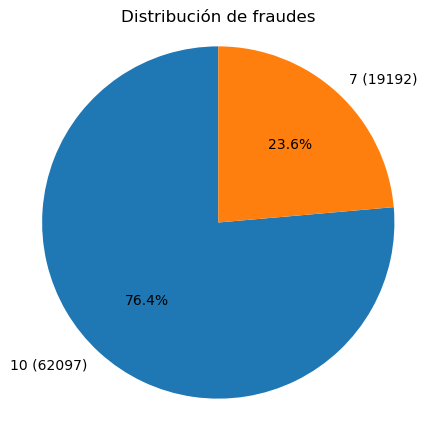

In [16]:
# Contar los valores únicos en la columna 'Resultado'
conteo_resultados = df['RESULTADO'].value_counts()

# Crear un gráfico de torta con los valores agregados a las etiquetas
plt.figure(figsize=(5, 5))
plt.pie(conteo_resultados, labels=[f'{label} ({count})' for label, count in conteo_resultados.items()], autopct='%1.1f%%', startangle=90)
plt.title('Distribución de fraudes')
plt.axis('equal')  # Para que el gráfico sea un círculo en lugar de una elipse

# Mostrar el gráfico de torta
plt.show()

In [17]:
conteo_resultados.items

<bound method Series.items of 10    62097
7     19192
Name: RESULTADO, dtype: int64>

Los valores de la columna RESULTADO corresponden a 10 cuando la inspección a la instalación se determina normal y 7 cuando la inspección arroja un fraude, que son las instalaciones que nos interesa perfilar.

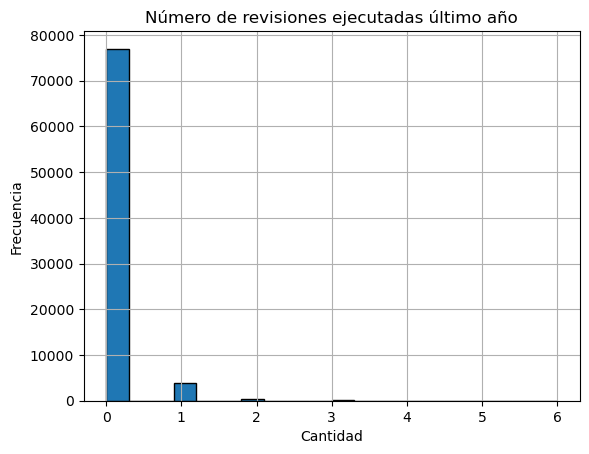

In [18]:
# Crear un histograma de la columna 'N294'
plt.hist(df['N294'], bins=20, edgecolor='k')
plt.xlabel('Cantidad')
plt.ylabel('Frecuencia')
plt.title('Número de revisiones ejecutadas último año')
plt.grid(True)

# Mostrar el histograma
plt.show()


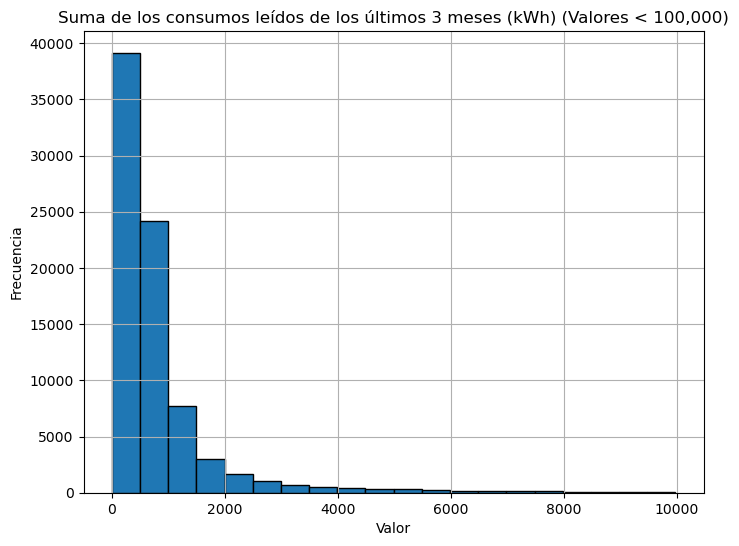

In [19]:
# Filtrar los valores menores a 100,000 en la columna 'N479'
valores_filtrados = df[df['N479'] < 10000]['N479']

# Crear un histograma para los valores filtrados
plt.figure(figsize=(8, 6))
plt.hist(valores_filtrados, bins=20, edgecolor='k')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.title('Suma de los consumos leídos de los últimos 3 meses (kWh) (Valores < 100,000)')
plt.grid(True)

# Mostrar el histograma
plt.show()

In [20]:
df.describe()

,RESULTADO,N404,N534,N402,N435,N436,N665,N637,N635,N633,...,N162,N257,ID_UC_PHASE,ID_REGION,ID_UC_METER_TYPE,ID_UC_CLASS,ID_LOCALITY,ID_UC_READING_CYCLE,ID_MUNICIPALITY,UC_COL_ID_03
count,81289.000000,81289.000000,81289.000000,81289.000000,81289.000000,81289.000000,81289.000000,81289.000000,81289.000000,81289.000000,...,81289.000000,81289.000000,81289.000000,81289.000000,81289.000000,81289.000000,81289.000000,81289.000000,81289.000000,81289.000000
mean,9.291712,2.527292,2.527292,6.208085,472.932528,575.289932,241.986591,441.634108,412.869061,382.319281,...,452.855287,0.356875,2.671468,29.165816,1.414041,1.542976,1.347193,2955.403228,140.092620,48.671481
std,1.274053,0.994880,0.994880,171.884711,2279.167552,2871.987513,2047.213631,2539.832725,2320.490356,2184.128929,...,2021.377190,3.425126,1.460121,12.492953,1.621197,3.377297,0.843955,1182.272559,83.640184,24.802851
min,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-16639.000000,-194.000000,-194.000000,-194.000000,...,3.000000,0.000000,1.000000,10.000000,0.000000,1.000000,1.000000,1001.000000,101.000000,1.000000
25%,10.000000,3.000000,3.000000,0.000000,144.000000,165.750000,1.000000,91.000000,84.000000,76.000000,...,119.000000,0.000000,1.000000,20.000000,0.000000,1.000000,1.000000,2025.000000,102.000000,24.000000
50%,10.000000,3.000000,3.000000,0.000000,286.500000,324.750000,74.000000,196.000000,187.000000,176.000000,...,222.333333,0.000000,2.000000,30.000000,0.000000,1.000000,1.000000,3005.000000,106.000000,46.000000
75%,10.000000,3.000000,3.000000,0.000000,473.000000,575.000000,214.000000,442.000000,413.000000,382.000000,...,453.000000,0.000000,4.000000,40.000000,3.000000,1.000000,1.000000,4001.000000,113.000000,72.000000
max,10.000000,3.000000,3.000000,25500.000000,334181.000000,393700.500000,241336.000000,260990.000000,224052.000000,229284.000000,...,205766.666667,118.000000,7.000000,50.000000,7.000000,28.000000,4.000000,5086.000000,408.000000,90.000000


In [21]:
#Tamaño del dataset
print(f"Número de observaciones en la base de datos: {df.shape[0]}")
print(f"Número de columnas en la base de datos: {df.shape[1]}")

Número de observaciones en la base de datos: 81289
Número de columnas en la base de datos: 329


#### _Cálculo de componentes principales con PyPI_

In [22]:
# PCA para atributos numéricos
# MCA para atributos categóricos

target = df['RESULTADO']
target = target.replace({10: 0, 7: 1})
pca_data = df[lista_variables_numericas]
pca_data = pca_data.drop(['RESULTADO'], axis=1)


Se transformó los valores de  la  variable  resultado,  en  la  tabla  de  SAP  HANA  fraude  se encuentra codificado con un 7 mientras normal con un 10, se usaron los valores de 1 para  la  clase  objetivo,  en  este  caso,  fraude;  y  0  para  las  instalaciones normales.

El primer paso que se debe hacer es la estandarización de variables. Esto es necesario ya que las variables pueden tener escalas diferentes y por lo tanto no tendrían varianzas comparables. Sin estandarización, las variables con mayor magnitud podrían dominar los componentes principales, lo cual llevaría a una interpretación errónea. Al tener los datos estandarizados con media cero y varianza 1, nos aseguramos de capturar la mayor información posible al momento de realizar PCA en las diferentes direcciones:

In [23]:
# Estandarización de datos
scaler = StandardScaler()
Z = scaler.fit_transform(pca_data)
Z = pd.DataFrame(Z)

In [24]:
# Inicializamos el objeto PCA
model = pca(n_components=25)

# Ajustamos el PCA a nuestros datos 
df_pca = model.fit_transform(Z)
df_pca

array([[-0.47533982, 11.31402601, -1.50011513, ...,  0.1385295 ,
        -0.03399091, -0.19662452],
       [-0.35444913, 11.31295662, -1.49360806, ...,  0.13232334,
        -0.02581448, -0.18731841],
       [-0.19681656, 10.9753212 , -1.41939395, ...,  0.01944521,
        -0.02773606, -0.19797722],
       ...,
       [-0.08824409, 12.26400132, -1.66435245, ...,  0.42078236,
        -0.01413716, -0.15140557],
       [-1.87598631,  4.94596269, -1.95157522, ..., -0.181309  ,
         0.86003422, -0.19329589],
       [-1.91000239, -3.14346556, -1.20265213, ..., -0.81369124,
         0.44343584, -0.10778526]])

A continuación, calculamos la proporción de varianza contenida en cada componente principal:

In [25]:
Z = pd.DataFrame(Z)
# Matriz de varianza
S = Z.cov()
pd.set_option('display.float_format', '{:.5f}'.format)
S

,0,1,2,3,4,5,6,7,8,9,...,309,310,311,312,313,314,315,316,317,318
0,1.00001,1.00001,-0.05271,0.00756,0.00900,0.00827,0.00916,0.00929,0.00857,0.00506,...,0.00951,-0.02606,0.00769,0.00945,-0.00054,0.00742,0.00926,0.00961,0.00954,0.03329
1,1.00001,1.00001,-0.05271,0.00756,0.00900,0.00827,0.00916,0.00929,0.00857,0.00506,...,0.00951,-0.02606,0.00769,0.00945,-0.00054,0.00742,0.00926,0.00961,0.00954,0.03329
2,-0.05271,-0.05271,1.00001,0.00096,0.00472,-0.00001,0.01479,0.00331,0.00344,0.00225,...,0.00333,0.00885,0.00207,0.00469,0.01586,0.00311,0.00633,0.00336,0.00649,-0.00341
3,0.00756,0.00756,0.00096,1.00001,0.91483,0.79642,0.84193,0.84316,0.86156,0.82369,...,0.87474,-0.00498,0.84832,0.88270,-0.00986,0.88462,0.85013,0.87036,0.74897,-0.00733
4,0.00900,0.00900,0.00472,0.91483,1.00001,0.84635,0.91588,0.90937,0.88850,0.85994,...,0.88469,-0.02550,0.89364,0.84417,-0.02390,0.86365,0.78116,0.88091,0.68629,-0.00539
5,0.00827,0.00827,-0.00001,0.79642,0.84635,1.00001,0.88482,0.86879,0.89467,0.92954,...,0.86274,-0.01716,0.86115,0.83881,-0.01903,0.86016,0.77330,0.86011,0.69483,-0.00763
6,0.00916,0.00916,0.01479,0.84193,0.91588,0.88482,1.00001,0.97692,0.95289,0.91139,...,0.94866,-0.03726,0.95671,0.90556,-0.03317,0.93077,0.83357,0.94715,0.76992,-0.00738
7,0.00929,0.00929,0.00331,0.84316,0.90937,0.86879,0.97692,1.00001,0.96240,0.90899,...,0.96290,-0.04058,0.97403,0.91487,-0.03410,0.93757,0.84447,0.96179,0.78639,-0.00770
8,0.00857,0.00857,0.00344,0.86156,0.88850,0.89467,0.95289,0.96240,1.00001,0.92790,...,0.97060,-0.02909,0.97106,0.94159,-0.03869,0.96621,0.86597,0.96926,0.80496,-0.00724
9,0.00506,0.00506,0.00225,0.82369,0.85994,0.92954,0.91139,0.90899,0.92790,1.00001,...,0.90365,-0.01895,0.90222,0.87969,-0.02247,0.90085,0.81515,0.90196,0.74756,-0.00345


In [26]:
eig_val, eig_vec = np.linalg.eig(S)
eig_val[0:50]

array([155.86698032+0.j,  23.62584594+0.j,  10.34065176+0.j,
         7.84890037+0.j,   6.87622883+0.j,   5.69612723+0.j,
         5.47626306+0.j,   5.34407874+0.j,   5.04553336+0.j,
         4.46865835+0.j,   3.85963716+0.j,   3.73810504+0.j,
         3.58586011+0.j,   3.31046048+0.j,   3.1363125 +0.j,
         2.86742432+0.j,   2.67297313+0.j,   2.44964482+0.j,
         2.25563441+0.j,   2.20256081+0.j,   2.10999058+0.j,
         1.99927819+0.j,   2.01261474+0.j,   1.86905386+0.j,
         1.67201436+0.j,   1.58936781+0.j,   1.50715008+0.j,
         1.47198834+0.j,   1.31097385+0.j,   1.28492329+0.j,
         1.26758181+0.j,   1.21645776+0.j,   1.2086083 +0.j,
         1.16184938+0.j,   1.11159766+0.j,   1.07024184+0.j,
         0.83294019+0.j,   0.86460437+0.j,   0.8795748 +0.j,
         0.92434929+0.j,   1.03471272+0.j,   0.97853138+0.j,
         0.98640121+0.j,   1.01141619+0.j,   1.00332392+0.j,
         0.82004022+0.j,   0.79029793+0.j,   0.76865812+0.j,
         0.73315779+0.j,

In [27]:
var_e=eig_val/sum(eig_val)
var_e[0:50]

array([0.48860521+0.j, 0.0740613 +0.j, 0.03241544+0.j, 0.0246044 +0.j,
       0.02155531+0.j, 0.01785598+0.j, 0.01716676+0.j, 0.01675239+0.j,
       0.01581652+0.j, 0.01400816+0.j, 0.01209903+0.j, 0.01171805+0.j,
       0.0112408 +0.j, 0.01037749+0.j, 0.00983158+0.j, 0.00898868+0.j,
       0.00837912+0.j, 0.00767904+0.j, 0.00707087+0.j, 0.00690449+0.j,
       0.00661431+0.j, 0.00626725+0.j, 0.00630906+0.j, 0.00585903+0.j,
       0.00524136+0.j, 0.00498228+0.j, 0.00472455+0.j, 0.00461433+0.j,
       0.00410959+0.j, 0.00402792+0.j, 0.00397356+0.j, 0.0038133 +0.j,
       0.00378869+0.j, 0.00364212+0.j, 0.00348459+0.j, 0.00335495+0.j,
       0.00261107+0.j, 0.00271033+0.j, 0.00275725+0.j, 0.00289761+0.j,
       0.00324357+0.j, 0.00306746+0.j, 0.00309213+0.j, 0.00317054+0.j,
       0.00314518+0.j, 0.00257063+0.j, 0.00247739+0.j, 0.00240956+0.j,
       0.00229827+0.j, 0.00225289+0.j])

C:\Users\User\anaconda3\envs\MIAD\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


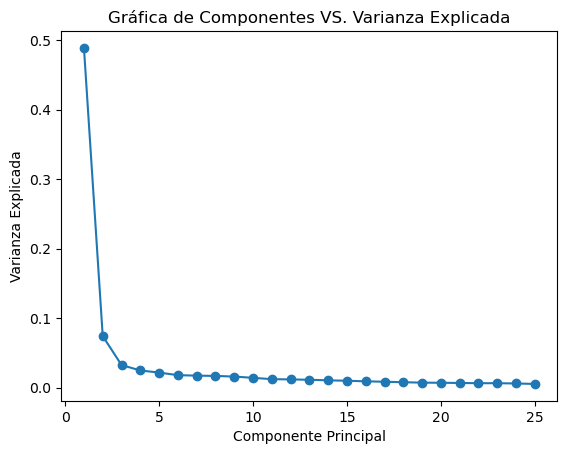

In [28]:
# Gráfica de los eigenvalores para determinar el número de componentes principales
plt.plot(range(1, 26), var_e[0:25], marker='o')
# Etiquetas y título
plt.xlabel('Componente Principal')
plt.ylabel('Varianza Explicada')
plt.title('Gráfica de Componentes VS. Varianza Explicada')

# Mostrar el gráfico
plt.show()

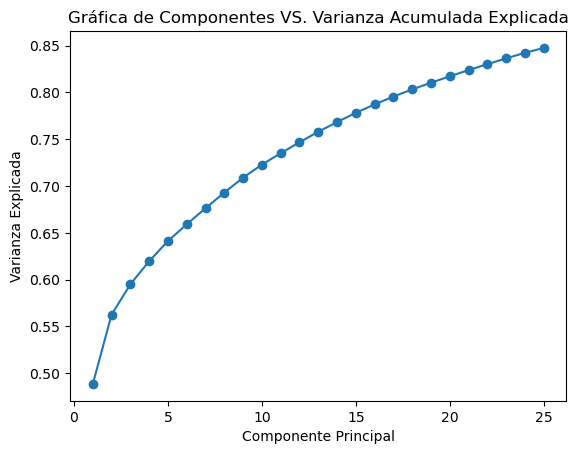

In [29]:
plt.plot(range(1,26), np.cumsum(var_e[0:25]), marker='o')
# Etiquetas y título
plt.xlabel('Componente Principal')
plt.ylabel('Varianza Explicada')
plt.title('Gráfica de Componentes VS. Varianza Acumulada Explicada')

# Mostrar el gráfico
plt.show()

In [30]:
np.cumsum(var_e[0:25])

array([0.48860521+0.j, 0.56266651+0.j, 0.59508195+0.j, 0.61968635+0.j,
       0.64124166+0.j, 0.65909764+0.j, 0.6762644 +0.j, 0.69301679+0.j,
       0.70883332+0.j, 0.72284148+0.j, 0.7349405 +0.j, 0.74665856+0.j,
       0.75789936+0.j, 0.76827685+0.j, 0.77810843+0.j, 0.78709711+0.j,
       0.79547624+0.j, 0.80315528+0.j, 0.81022615+0.j, 0.81713064+0.j,
       0.82374495+0.j, 0.8300122 +0.j, 0.83632126+0.j, 0.84218029+0.j,
       0.84742165+0.j])

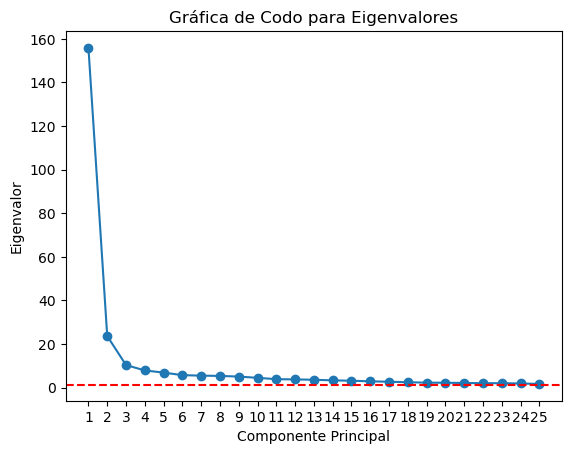

In [31]:
# Gráfica de los eigenvalores para determinar el número de componentes principales
plt.plot(range(1, 26), eig_val[0:25], marker='o')
# Etiquetas y título
plt.xlabel('Componente Principal')
plt.ylabel('Eigenvalor')
plt.title('Gráfica de Codo para Eigenvalores')

plt.axhline(y=1, color='r', linestyle='--') # Línea horizontal para el criterio de eigenvalor > 1
plt.xticks(ticks=range(1, len(eig_val[0:25]) + 1))
# Mostrar el gráfico
plt.show()

Se omiten los atributos que calcular valores mensuales puesto que están incluidos en los atributos que calculan los promedios de estos

In [32]:
lista_at_men1 = ["N163", "N171", "N173", "N174", "N177", "N180", "N181", "N182", "N184", "N187", "N201", "N202", "N225", "N226", "N245", "N246", "N255", "N259", "N267", "N270", "N271", "N272", "N273", "N274", "N275", "N276", "N329", "N330", "N331", "N332", "N333", "N334", "N335", "N336", "N337", "N338", "N339", "N340", "N341", "N342", "N363", "N419", "N421", "N422", "N445", "N446", "N447", "N448", "N449", "N450", "N451", "N452", "N453", "N454", "N455", "N456", "N457", "N458", "N459", "N460", "N461", "N462", "N463", "N464", "N465", "N466", "N467", "N468", "N469", "N470", "N471", "N472", "N473", "N474", "N475", "N476", "N477", "N478", "N570", "N571", "N572", "N573", "N582", "N583", "N597", "N598", "N599", "N600", "N602", "N603", "N604", "N605", "N606", "N607", "N608", "N609", "N610", "N611", "N612", "N613", "N614", "N615", "N616", "N617", "N618", "N619", "N623", "N624", "N625", "N646", "N649", "N654"]
lista_at_men2 = ['N171', 'N177', 'N245', 'N246', 'N267', 'N271', 'N272', 'N273', 'N274', 'N276', 'N331', 'N332', 'N333', 'N334', 'N335', 'N336', 'N337', 'N338', 'N339', 'N340', 'N341', 'N342', 'N419', 'N447', 'N454', 'N570', 'N571', 'N597', 'N598', 'N599', 'N600', 'N605', 'N606', 'N607', 'N614', 'N615', 'N616', 'N617', 'N618', 'N619', 'N623', 'N624', 'N625', 'N646']
lista_at_men = list((Counter(lista_at_men1)-Counter(lista_at_men2)).elements())

In [33]:
pca_data = pca_data.drop(lista_at_men, axis=1)
pca_data.shape

(81289, 251)

In [34]:
# Estandarización de datos
scaler = StandardScaler()
Z = scaler.fit_transform(pca_data)
Z

array([[-2.54031407e+00, -2.54031407e+00, -3.61179472e-02, ...,
        -1.55541147e-01, -1.64668591e-01, -1.04193853e-01],
       [-2.54031407e+00, -2.54031407e+00, -3.61179472e-02, ...,
        -1.05408364e-01, -1.08271051e-01, -1.04193853e-01],
       [-1.53516130e+00, -1.53516130e+00, -3.61179472e-02, ...,
        -4.07634599e-02, -3.55479073e-02, -1.04193853e-01],
       ...,
       [-2.54031407e+00, -2.54031407e+00, -3.61179472e-02, ...,
         1.34336584e-04,  7.15917804e-05, -1.04193853e-01],
       [-1.53516130e+00, -1.53516130e+00, -3.61179472e-02, ...,
        -1.63808658e-01, -2.00288090e-01, -1.04193853e-01],
       [ 4.75144242e-01,  4.75144242e-01, -3.61179472e-02, ...,
        -1.39416568e-01, -1.37294347e-01, -1.04193853e-01]])

In [35]:
# Inicializamos el objeto PCA
model = pca(n_components=25)

# Ajustamos el PCA a nuestros datos 
df_pca = model.fit_transform(Z)
df_pca=pd.DataFrame(df_pca)
nuevos_nombres = [f'PC{i + 1}' for i in range(25)]
df_pca.columns = nuevos_nombres
# Agregar la columna "RESULTADO" de vuelta al DataFrame resultante
df_pca['RESULTADO'] = target
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,RESULTADO
0,-0.46192,11.31074,-1.48873,0.09962,-0.84520,-0.44052,-0.25526,-0.47195,0.82110,0.07785,...,0.02832,0.05036,0.15420,0.09833,0.07239,0.12025,0.00819,-0.02951,-0.19152,0
1,-0.35050,11.31075,-1.48743,0.11333,-0.84693,-0.45750,-0.16027,-0.44078,0.81172,0.07790,...,0.03149,0.04966,0.15377,0.09683,0.07106,0.12080,0.00940,-0.01664,-0.19213,0
2,-0.20421,10.97447,-1.41955,0.11957,-0.78170,-0.47772,-0.06363,-0.28339,0.65352,0.04148,...,-0.07778,-0.01633,0.12418,-0.08734,0.09103,0.00632,0.02358,-0.00718,-0.19864,0
3,-0.12764,12.26434,-1.67223,0.14913,-1.08400,-0.56020,0.06680,-0.65709,1.28431,0.19588,...,0.13747,0.04838,0.23664,0.29858,-0.05908,0.43821,0.00244,-0.02187,-0.21308,0
4,-0.12764,12.26434,-1.67223,0.14913,-1.08400,-0.56020,0.06680,-0.65709,1.28431,0.19588,...,0.13747,0.04838,0.23664,0.29858,-0.05908,0.43821,0.00244,-0.02187,-0.21308,0


In [36]:
Z = pd.DataFrame(Z)
# Matriz de varianza
S = Z.cov()
pd.set_option('display.float_format', '{:.5f}'.format)
S

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
0,1.00001,1.00001,-0.05271,0.00756,0.00900,0.00827,0.00916,0.00929,0.00857,0.00506,...,0.00951,-0.02606,0.00769,0.00945,-0.00054,0.00742,0.00926,0.00961,0.00954,0.03329
1,1.00001,1.00001,-0.05271,0.00756,0.00900,0.00827,0.00916,0.00929,0.00857,0.00506,...,0.00951,-0.02606,0.00769,0.00945,-0.00054,0.00742,0.00926,0.00961,0.00954,0.03329
2,-0.05271,-0.05271,1.00001,0.00096,0.00472,-0.00001,0.01479,0.00331,0.00344,0.00225,...,0.00333,0.00885,0.00207,0.00469,0.01586,0.00311,0.00633,0.00336,0.00649,-0.00341
3,0.00756,0.00756,0.00096,1.00001,0.91483,0.79642,0.84193,0.84316,0.86156,0.82369,...,0.87474,-0.00498,0.84832,0.88270,-0.00986,0.88462,0.85013,0.87036,0.74897,-0.00733
4,0.00900,0.00900,0.00472,0.91483,1.00001,0.84635,0.91588,0.90937,0.88850,0.85994,...,0.88469,-0.02550,0.89364,0.84417,-0.02390,0.86365,0.78116,0.88091,0.68629,-0.00539
5,0.00827,0.00827,-0.00001,0.79642,0.84635,1.00001,0.88482,0.86879,0.89467,0.92954,...,0.86274,-0.01716,0.86115,0.83881,-0.01903,0.86016,0.77330,0.86011,0.69483,-0.00763
6,0.00916,0.00916,0.01479,0.84193,0.91588,0.88482,1.00001,0.97692,0.95289,0.91139,...,0.94866,-0.03726,0.95671,0.90556,-0.03317,0.93077,0.83357,0.94715,0.76992,-0.00738
7,0.00929,0.00929,0.00331,0.84316,0.90937,0.86879,0.97692,1.00001,0.96240,0.90899,...,0.96290,-0.04058,0.97403,0.91487,-0.03410,0.93757,0.84447,0.96179,0.78639,-0.00770
8,0.00857,0.00857,0.00344,0.86156,0.88850,0.89467,0.95289,0.96240,1.00001,0.92790,...,0.97060,-0.02909,0.97106,0.94159,-0.03869,0.96621,0.86597,0.96926,0.80496,-0.00724
9,0.00506,0.00506,0.00225,0.82369,0.85994,0.92954,0.91139,0.90899,0.92790,1.00001,...,0.90365,-0.01895,0.90222,0.87969,-0.02247,0.90085,0.81515,0.90196,0.74756,-0.00345


In [37]:
eig_val, eig_vec = np.linalg.eig(S)
eig_val[0:50]

array([100.38844756+0.j,  23.62243815+0.j,  10.33497139+0.j,
         7.00924348+0.j,   5.34579299+0.j,   5.07673291+0.j,
         4.63755103+0.j,   4.49962887+0.j,   3.890874  +0.j,
         3.74121434+0.j,   3.72218971+0.j,   3.6016282 +0.j,
         3.49176028+0.j,   3.29375786+0.j,   3.13297078+0.j,
         2.67243852+0.j,   2.44572136+0.j,   2.25565984+0.j,
         2.2026009 +0.j,   2.10658304+0.j,   1.99380289+0.j,
         2.01240549+0.j,   1.87065032+0.j,   1.83887758+0.j,
         1.66960899+0.j,   1.50494407+0.j,   1.47183656+0.j,
         1.31081686+0.j,   1.26792713+0.j,   1.21387753+0.j,
         1.1674222 +0.j,   1.14570636+0.j,   1.11182645+0.j,
         1.07342712+0.j,   1.03802897+0.j,   1.01173565+0.j,
         1.00313273+0.j,   0.98555654+0.j,   0.97529281+0.j,
         0.9207713 +0.j,   0.87923577+0.j,   0.8637195 +0.j,
         0.82740684+0.j,   0.82307206+0.j,   0.81126241+0.j,
         0.77928225+0.j,   0.75948982+0.j,   0.60867054+0.j,
         0.73274412+0.j,

Proporción de varianza contenida en cada componente principal:

In [38]:
var_e=eig_val/sum(eig_val)
var_e[0:50]

array([0.39994905+0.j, 0.09411214+0.j, 0.04117468+0.j, 0.02792493+0.j,
       0.02129772+0.j, 0.02022578+0.j, 0.01847607+0.j, 0.01792659+0.j,
       0.0155013 +0.j, 0.01490505+0.j, 0.01482926+0.j, 0.01434894+0.j,
       0.01391122+0.j, 0.01312238+0.j, 0.0124818 +0.j, 0.01064703+0.j,
       0.00974379+0.j, 0.00898658+0.j, 0.00877519+0.j, 0.00839266+0.j,
       0.00794334+0.j, 0.00801745+0.j, 0.0074527 +0.j, 0.00732612+0.j,
       0.00665175+0.j, 0.00599572+0.j, 0.00586382+0.j, 0.00522231+0.j,
       0.00505144+0.j, 0.00483611+0.j, 0.00465103+0.j, 0.00456451+0.j,
       0.00442953+0.j, 0.00427655+0.j, 0.00413552+0.j, 0.00403077+0.j,
       0.0039965 +0.j, 0.00392647+0.j, 0.00388558+0.j, 0.00366837+0.j,
       0.00350289+0.j, 0.00344107+0.j, 0.0032964 +0.j, 0.00327913+0.j,
       0.00323208+0.j, 0.00310467+0.j, 0.00302582+0.j, 0.00242495+0.j,
       0.00291926+0.j, 0.00285086+0.j])

C:\Users\User\anaconda3\envs\MIAD\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


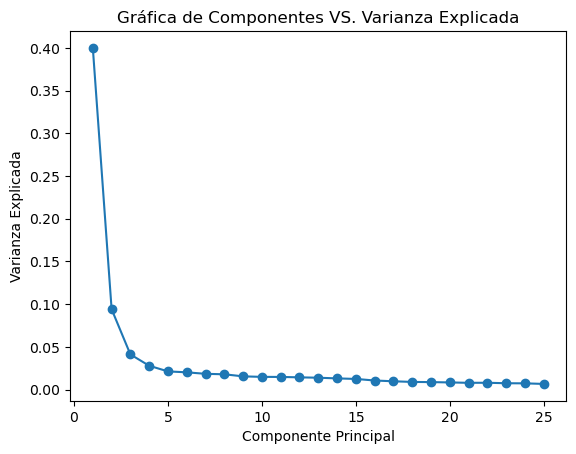

In [39]:
# Gráfica de los eigenvalores para determinar el número de componentes principales
plt.plot(range(1, 26), var_e[0:25], marker='o')
# Etiquetas y título
plt.xlabel('Componente Principal')
plt.ylabel('Varianza Explicada')
plt.title('Gráfica de Componentes VS. Varianza Explicada')

# Mostrar el gráfico
plt.show()

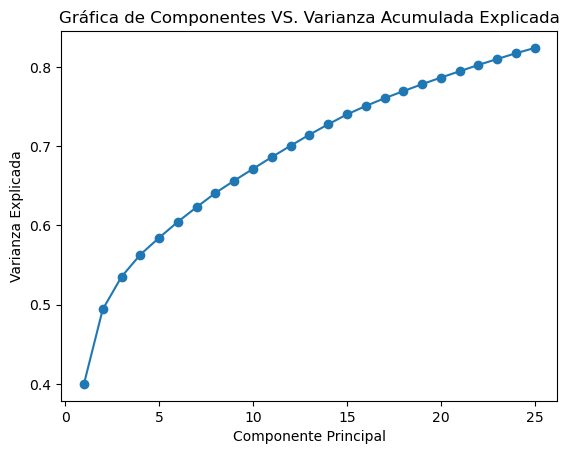

In [40]:
plt.plot(range(1,26), np.cumsum(var_e[0:25]), marker='o')
# Etiquetas y título
plt.xlabel('Componente Principal')
plt.ylabel('Varianza Explicada')
plt.title('Gráfica de Componentes VS. Varianza Acumulada Explicada')

# Mostrar el gráfico
plt.show()

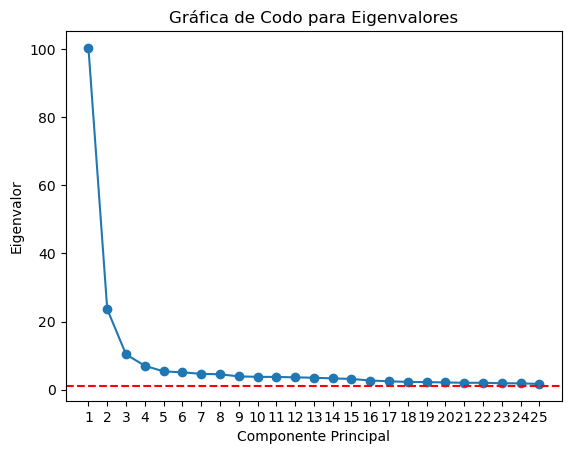

In [41]:
# Gráfica de los eigenvalores para determinar el número de componentes principales
plt.plot(range(1, 26), eig_val[0:25], marker='o')
# Etiquetas y título
plt.xlabel('Componente Principal')
plt.ylabel('Eigenvalor')
plt.title('Gráfica de Codo para Eigenvalores')

plt.axhline(y=1, color='r', linestyle='--') # Línea horizontal para el criterio de eigenvalor > 1
plt.xticks(ticks=range(1, len(eig_val[0:25]) + 1))
# Mostrar el gráfico
plt.show()

In [42]:
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,RESULTADO
0,-0.46192,11.31074,-1.48873,0.09962,-0.84520,-0.44052,-0.25526,-0.47195,0.82110,0.07785,...,0.02832,0.05036,0.15420,0.09833,0.07239,0.12025,0.00819,-0.02951,-0.19152,0
1,-0.35050,11.31075,-1.48743,0.11333,-0.84693,-0.45750,-0.16027,-0.44078,0.81172,0.07790,...,0.03149,0.04966,0.15377,0.09683,0.07106,0.12080,0.00940,-0.01664,-0.19213,0
2,-0.20421,10.97447,-1.41955,0.11957,-0.78170,-0.47772,-0.06363,-0.28339,0.65352,0.04148,...,-0.07778,-0.01633,0.12418,-0.08734,0.09103,0.00632,0.02358,-0.00718,-0.19864,0
3,-0.12764,12.26434,-1.67223,0.14913,-1.08400,-0.56020,0.06680,-0.65709,1.28431,0.19588,...,0.13747,0.04838,0.23664,0.29858,-0.05908,0.43821,0.00244,-0.02187,-0.21308,0
4,-0.12764,12.26434,-1.67223,0.14913,-1.08400,-0.56020,0.06680,-0.65709,1.28431,0.19588,...,0.13747,0.04838,0.23664,0.29858,-0.05908,0.43821,0.00244,-0.02187,-0.21308,0


In [43]:
df_pca.shape

(81289, 26)

In [44]:
# Copia todas las columnas excepto 'RESULTADO'
columns_to_cluster = df_pca.drop(columns=['RESULTADO'])

# Especifica el número de clusters que deseas
n_clusters = 18  # Ajusta este valor según tu preferencia
np.random.seed(1)
# Aplica K-Means a las columnas numéricas
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
df_pca['cluster'] = kmeans.fit_predict(columns_to_cluster)
# Calcula el conteo y el porcentaje de 0 y 1 en cada cluster
cluster_result_df = pd.DataFrame()

for cluster_label in range(n_clusters):
    cluster_data = df_pca[df_pca['cluster'] == cluster_label]
    cluster_counts = cluster_data['RESULTADO'].value_counts()
    cluster_percentages = cluster_counts / len(cluster_data) * 100
    
    cluster_index = f'Cluster {cluster_label}'
    cluster_result_df.loc[cluster_index, 'conteo_0'] = cluster_counts.get(0, 0)
    cluster_result_df.loc[cluster_index, 'conteo_1'] = cluster_counts.get(1, 0)
    cluster_result_df.loc[cluster_index, 'porcentaje_0'] = cluster_percentages.get(0, 0)
    cluster_result_df.loc[cluster_index, 'porcentaje_1'] = cluster_percentages.get(1, 0)

# Asegúrate de que las columnas de conteo sean enteros
cluster_result_df[['conteo_0', 'conteo_1']] = cluster_result_df[['conteo_0', 'conteo_1']].astype(int)

C:\Users\User\anaconda3\envs\MIAD\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


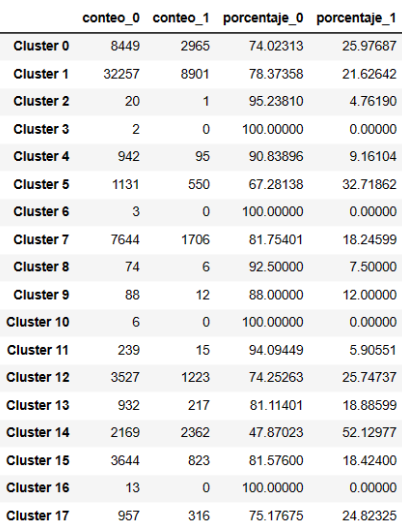